In [1]:
import glob
import sys
import math
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append("../../")

from helpers.experiment import experiment
from helpers.assess import resolve_sample_weight
from helpers.split import make_train_test_split, tag_label_feature_split
import matplotlib.pyplot as plt
import math
from helpers.keras_graph_callback import KerasGraphCallback
from sklearn.utils.class_weight import compute_class_weight

/usr/local/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_pickle('../../datasets/dataset_10_melspecs.pickle')
df = df.sample(frac=1) #shuffle

In [3]:
_, (y, le), X = tag_label_feature_split(
    df, label_format="encoded"
)

In [4]:
# extract 2D numpy array from pandas dataframe
X_raw = np.array(list(X.to_numpy()[:,0]))
# choosing ~5s clip to make square 96x96 spectrogram frame
X_raw_square = X_raw[:,0:96,200:296]



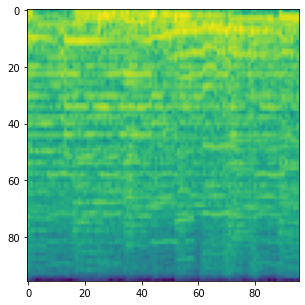

In [5]:
scaler = StandardScaler()
# flatten 2D array to fit to "overall" mean / variance
scaler.fit(X_raw_square.reshape(-1,1))
# must be reshaped for transformation then restored to original shape
# X = scaler.transform(X_raw_square.reshape(-1, 1)).reshape(X_raw_square.shape)
X = X_raw_square

In [25]:
X[20]

array([[ -7.689842 , -15.230065 ,  -7.6464396, ..., -40.991436 ,
        -43.11333  , -41.593674 ],
       [  5.6716347, -10.978927 ,   3.152579 , ..., -43.786636 ,
        -49.191475 , -45.802406 ],
       [ 11.278284 ,   0.9358165,   8.794279 , ..., -43.657433 ,
        -47.158176 , -52.841915 ],
       ...,
       [-29.120996 , -31.186981 , -32.946014 , ..., -45.613167 ,
        -45.981037 , -47.168304 ],
       [-34.89985  , -36.33376  , -39.443806 , ..., -57.20075  ,
        -67.4374   , -65.04853  ],
       [-51.468483 , -53.54096  , -53.092575 , ..., -78.04954  ,
        -79.59098  , -81.65247  ]], dtype=float32)

array([[ -7.689842 , -15.230065 ,  -7.6464396, ..., -40.991436 ,
        -43.11333  , -41.593674 ],
       [  5.6716347, -10.978927 ,   3.152579 , ..., -43.786636 ,
        -49.191475 , -45.802406 ],
       [ 11.278284 ,   0.9358165,   8.794279 , ..., -43.657433 ,
        -47.158176 , -52.841915 ],
       ...,
       [-29.120996 , -31.186981 , -32.946014 , ..., -45.613167 ,
        -45.981037 , -47.168304 ],
       [-34.89985  , -36.33376  , -39.443806 , ..., -57.20075  ,
        -67.4374   , -65.04853  ],
       [-51.468483 , -53.54096  , -53.092575 , ..., -78.04954  ,
        -79.59098  , -81.65247  ]], dtype=float32)

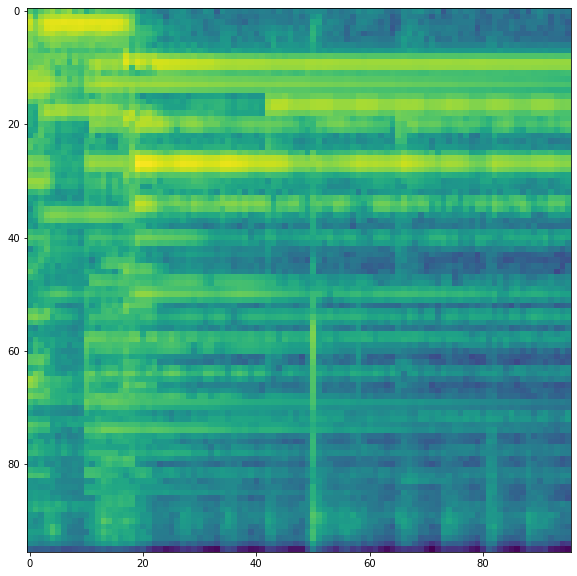

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(X[20])
X_raw_square[20]

In [6]:
X_train, X_validation, y_train, y_validation = make_train_test_split(
        X, y, test_size=0.3, random_state=10, stratify=y
    )
class_weight={i:c  for i,c in enumerate(compute_class_weight(class_weight='balanced',classes=le.transform(le.classes_),y=y_train))}

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (8,3), activation='relu', input_shape=(96, 96,1),name='conv_1'))
model.add(tf.keras.layers.MaxPooling2D((2, 2),name='pool_1'))
model.add(tf.keras.layers.Conv2D(16, (8,3), activation='relu',name='conv_2'))
model.add(tf.keras.layers.MaxPooling2D((2, 2),name='pool_2'))
model.add(tf.keras.layers.Conv2D(16, (8,3), activation='relu',name='conv_3'))
model.add(tf.keras.layers.MaxPooling2D((2, 2),name='pool_3'))
# model.add(tf.keras.layers.Conv2D(16, 4, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200, activation='relu'))
model.add(tf.keras.layers.Dropout(
        rate=0.5))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(
        rate=0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(
        rate=0.5))
model.add(tf.keras.layers.Dense(10))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=10, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight
)

Epoch 1/10
468/468 [==============================] - 43s 92ms/step - loss: 2.3517 - accuracy: 0.1249 - val_loss: 2.3016 - val_accuracy: 0.1731
Epoch 2/10
468/468 [==============================] - 50s 107ms/step - loss: 2.2711 - accuracy: 0.1881 - val_loss: 2.1486 - val_accuracy: 0.2501
Epoch 3/10
468/468 [==============================] - 62s 133ms/step - loss: 2.2245 - accuracy: 0.2350 - val_loss: 1.9971 - val_accuracy: 0.2946
Epoch 4/10
468/468 [==============================] - 59s 126ms/step - loss: 2.1760 - accuracy: 0.2599 - val_loss: 2.0138 - val_accuracy: 0.2900
Epoch 5/10
468/468 [==============================] - 59s 127ms/step - loss: 2.1252 - accuracy: 0.2732 - val_loss: 1.8881 - val_accuracy: 0.3138
Epoch 6/10
468/468 [==============================] - 57s 123ms/step - loss: 2.0823 - accuracy: 0.2763 - val_loss: 1.9182 - val_accuracy: 0.2964
Epoch 7/10
468/468 [==============================] - 53s 114ms/step - loss: 2.0185 - accuracy: 0.2888 - val_loss: 1.9114 - val_acc

----------------
Geeting activations of layer 1 : conv_1
Images size is 93 x 93
Number of channels is 16
Printing channels:


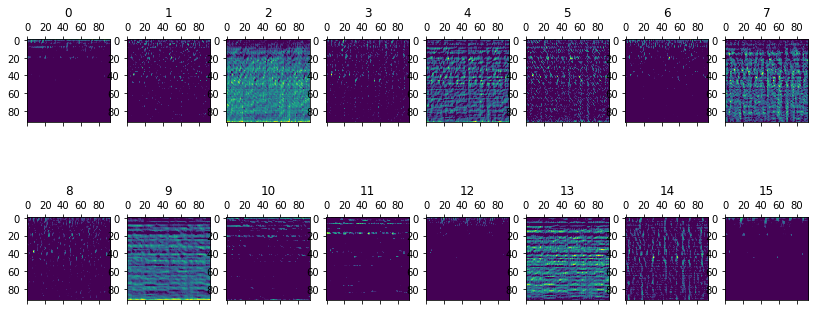

----------------
Geeting activations of layer 2 : pool_1
Images size is 46 x 46
Number of channels is 16
Printing channels:


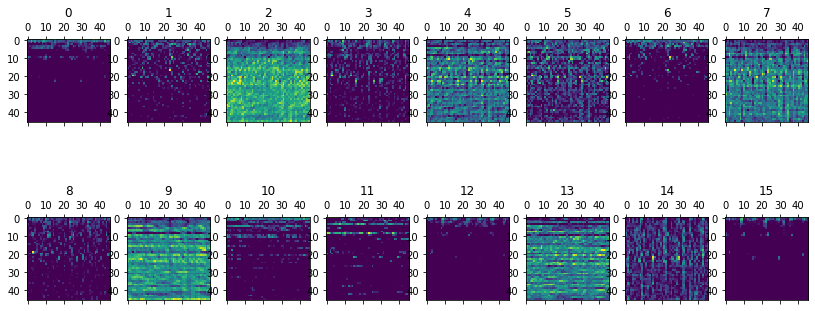

----------------
Geeting activations of layer 3 : conv_2
Images size is 43 x 43
Number of channels is 16
Printing channels:


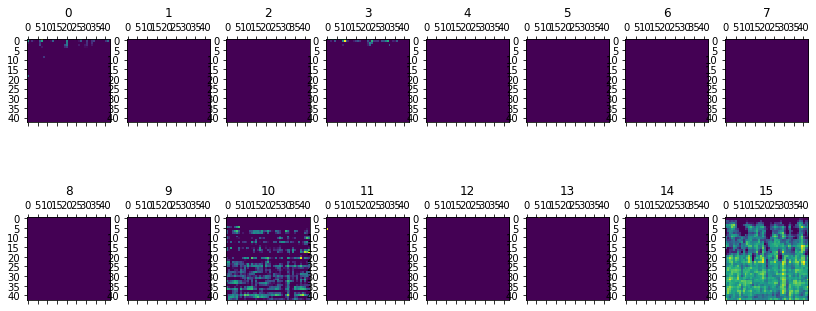

----------------
Geeting activations of layer 4 : pool_2
Images size is 21 x 21
Number of channels is 16
Printing channels:


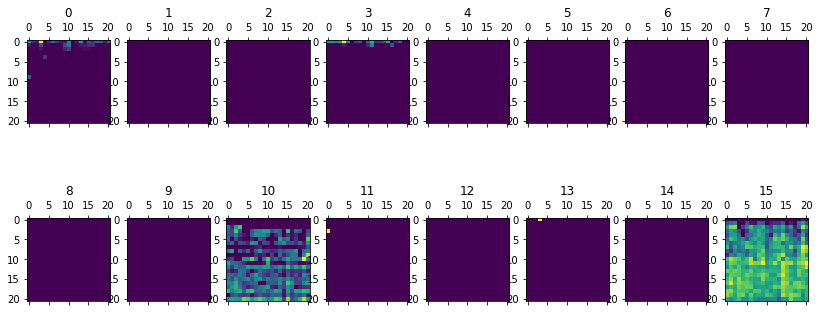

----------------
Geeting activations of layer 5 : conv_3
Images size is 18 x 18
Number of channels is 16
Printing channels:


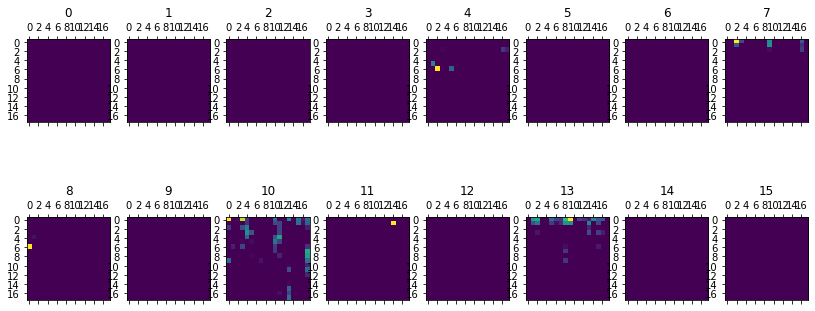

----------------
Geeting activations of layer 6 : pool_3
Images size is 9 x 9
Number of channels is 16
Printing channels:


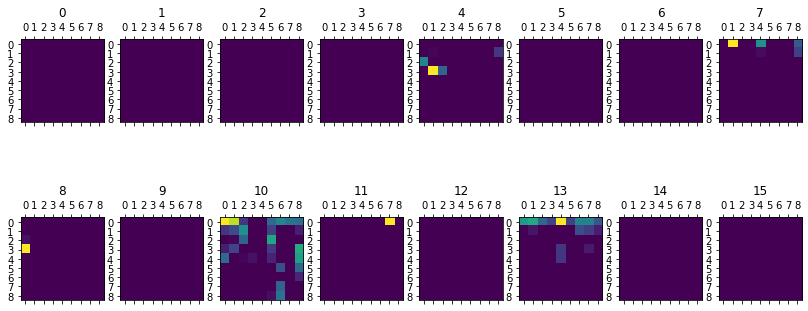

In [12]:
# outputs of the first 4 layers, which include conv2D and max pooling layers
from keras import models
img_tensor = np.expand_dims(X_train[2], axis = 0);
layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# grab layer names
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    if idx in (0,1,2,3,4,5):
        print('----------------')
        print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
        activation = layer

        # shape of layer activation
        print('Images size is', activation.shape[1], 'x', activation.shape[2])
        print('Number of channels is', activation.shape[3])

        # print channels
        print('Printing channels:')
        
        # define nrows and ncols depending on number of channels
        # if idx in (0,1):
        #     nrows, ncols = 4,8
        # if idx in (2,3):
        #    nrows, ncols = 8,8
        nrows, ncols = 2,8
        

        # plots
        channel=0
        
        f, axs = plt.subplots(nrows, ncols, figsize=(14,6))
        #if idx in (0,1):
        #    f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        #if idx in (2,3):
        #    f, axs = plt.subplots(nrows, ncols, figsize=(14,20))
            
        for i in range(nrows):
            for j in range(ncols):
                if i==0 and j==0:
                    channel=0
                else:
                    channel+=1

                axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                axs[i,j].set(title=str(channel))
                #axs[i,j].axis('off') # pay attention to the range of x and y axis
        plt.show()